# Customer Churn Prediction Model: The case of a bank

# Objective:
This project aims to build a machine learning model to predict whether bank customers will churn or not. The churn rate - rate at which bank customers stop doing business with the bank. 


# The dataset:

The dataset includes churn status for 10,000 customers and 14 attributes, such as:

Credit score,
Geographical location (Germany, France, Spain),
Gender (male, female),
Age,
Tenure (years as a bank customer),
Account balance,
Estimated salary,
Number of products purchased through the bank,
Credit card status (whether the customer has a credit card) Active member status (whether the customer is an active bank customer),

Additionally, the dataset has columns like row number, customer ID, and customer surname, which do not affect the customer's decision to leave the bank. Customer churn is defined as closing their bank account, indicated by the exit column in the dataset.

Of the 10,000 customers, only 2,037 (about 20%) have left the bank, showing a class imbalance. Due to this, generating synthetic data is recommended to balance the classes. Our goal is to understand how these attributes influence the exit status. 

In [92]:
# Let's set the experiment's name.
EXPERIMENT_NAME = "customer_churn_prediction_ai"  # MLflow experiment name

StatementMeta(, f0b881c3-c0bb-4915-9e39-929f42d17129, 124, Finished, Available, Finished)

# Load the dataset and upload it to microsoft fabric lakehouse
(i.e the Customer_churn_prediction_model_lakehouse we added to our notebook initially)

In [120]:
# We first Verify if custom data is being used. Because we're using some public sample data, set to False.
# If we were using custom data, we'll set this to True and ensure manual upload of the dataset.
USING_CUSTOM_DATA = False  # Set to True for custom datasets that need manual uploading

if not USING_CUSTOM_DATA:
    # Import required libraries
    import os
    import requests

     # Specify the remote URL of the data file
    data_url = "https://synapseaisolutionsa.blob.core.windows.net/public/bankcustomerchurn"
    
    # Set the filename for the downloaded data file
    file_name = "churn.csv"
    
    # Define the local directory path where the file will be stored
    download_path = "/lakehouse/default/Files/raw"

    # Verify the existence of the default lakehouse directory
    if not os.path.exists("/lakehouse/default"):
        # Raise an error if the default lakehouse directory is not found
        raise FileNotFoundError("Default lakehouse directory not found. Please add a lakehouse and restart the session.")

         # Ensure the download directory exists, create if it doesn't
    os.makedirs(download_path, exist_ok=True)
    
    # Verify if the file already exists in the specified download path
    if not os.path.exists(f"{download_path}/{file_name}"):
        # Download the file from the remote URL if it doesn't exist locally
        response = requests.get(f"{data_url}/{file_name}", timeout=30)
        
        # Save the downloaded content to a local file in write-binary mode
        with open(f"{download_path}/{file_name}", "wb") as file:
            file.write(response.content)
        
        # Notify that the demo data file has been successfully downloaded
        print("Demo data file has been downloaded into the lakehouse.")
    else:
        # Notify that the data file already exists locally, no need to download
        print("Data file already exists in the lakehouse.")   


StatementMeta(, f0b881c3-c0bb-4915-9e39-929f42d17129, 152, Finished, Available, Finished)

Data file already exists in the lakehouse.


#


In [121]:
# Record the notebook running time
import time

ts = time.time()

StatementMeta(, f0b881c3-c0bb-4915-9e39-929f42d17129, 153, Finished, Available, Finished)

# Read the raw data from the lakehouse to a dataframe

In [122]:
# Define the relative path to the CSV file
full_data_path = "Files/raw/churn.csv"

# Load the CSV file into a Spark DataFrame
df = (
    spark.read.format("csv")                # Set the file format to CSV
    .option("header", "true")               # Use the first row as column headers
    .option("inferSchema", "true")          # Automatically infer the schema of the CSV file
    .load(full_data_path)                   # Load the CSV file from the specified relative path
    .cache()                                # Cache the DataFrame in memory for faster access
)


StatementMeta(, f0b881c3-c0bb-4915-9e39-929f42d17129, 154, Finished, Available, Finished)

# Create pandas dataframe
This code converts the spark DataFrame to pandas DataFrame for easier processing and visualization.

In [123]:
# Convert the Spark DataFrame to a Pandas DataFrame for easier processing and visualization
df = df.toPandas()

StatementMeta(, f0b881c3-c0bb-4915-9e39-929f42d17129, 155, Finished, Available, Finished)

# Perform Exploratory data analysis 

In [124]:
import seaborn as sns  # Import Seaborn for advanced data visualization
sns.set_theme(style="whitegrid", palette="tab10", rc={'figure.figsize': (9, 6)})  # Set the theme for Seaborn plots

import matplotlib.pyplot as plt  # Import Matplotlib for creating static, animated, and interactive visualizations
import matplotlib.ticker as mticker  # Import ticker for controlling tick locators on axes
from matplotlib import rc, rcParams  # Import rc and rcParams to customize Matplotlib configurations

import numpy as np  # Import NumPy for numerical operations
import pandas as pd  # Import Pandas for data manipulation and analysis
import itertools  # Import itertools for creating iterators for efficient looping

StatementMeta(, f0b881c3-c0bb-4915-9e39-929f42d17129, 156, Finished, Available, Finished)

In [125]:
# Display the Spark DataFrame along with a summary
display(df, summary=True)

StatementMeta(, f0b881c3-c0bb-4915-9e39-929f42d17129, 157, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, 4a5721a3-cc04-4619-9bf9-cd2b642d20f8)

# Perform data cleaning 

In [126]:
def clean_data(df):
    """
    Clean the given DataFrame by performing the following steps:
    1. Drop rows with missing data across all columns.
    2. Remove duplicate rows based on 'RowNumber' and 'CustomerId'.
    3. Drop unnecessary columns: 'RowNumber', 'CustomerId', 'Surname'.
    
    Parameters:
    df (DataFrame): The input DataFrame to be cleaned.
    
    Returns:
    DataFrame: The cleaned DataFrame.
    """
    # Drop rows with missing data across all columns
    df.dropna(inplace=True)
    
    # Drop duplicate rows based on 'RowNumber' and 'CustomerId' columns
    df.drop_duplicates(subset=['RowNumber', 'CustomerId'], inplace=True)
    
    # Drop unnecessary columns: 'RowNumber', 'CustomerId', 'Surname'
    df.drop(columns=['RowNumber', 'CustomerId', 'Surname'], inplace=True)
    
    return df

# Create a copy of the original DataFrame and clean it
df_clean = clean_data(df.copy())

StatementMeta(, f0b881c3-c0bb-4915-9e39-929f42d17129, 158, Finished, Available, Finished)

# Define and separate the attributes.
Define a function to identify categorical, numerical, and target attributes

In [127]:
# Determine the dependent (target) attribute
dependent_variable_name = "Exited"
print("Dependent Variable:", dependent_variable_name)

# Determine the categorical attributes
categorical_variables = [col for col in df_clean.columns 
                         if df_clean[col].dtype == "object" or df_clean[col].nunique() <= 5 
                         and col != dependent_variable_name]
print("Categorical Variables:", categorical_variables)

# Determine the numerical attributes
numeric_variables = [col for col in df_clean.columns 
                     if df_clean[col].dtype != "object" and df_clean[col].nunique() > 5]
print("Numerical Variables:", numeric_variables)

StatementMeta(, f0b881c3-c0bb-4915-9e39-929f42d17129, 159, Finished, Available, Finished)

Dependent Variable: Exited
Categorical Variables: ['Geography', 'Gender', 'NumOfProducts', 'HasCrCard', 'IsActiveMember']
Numerical Variables: ['CreditScore', 'Age', 'Tenure', 'Balance', 'EstimatedSalary']


# Show the five number summary

Display the five-number summary (minimum, first quartile, median, third quartile, and maximum) for the numerical attributes using box plots.

StatementMeta(, f0b881c3-c0bb-4915-9e39-929f42d17129, 160, Finished, Available, Finished)

/tmp/ipykernel_15054/4195286904.py:9: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


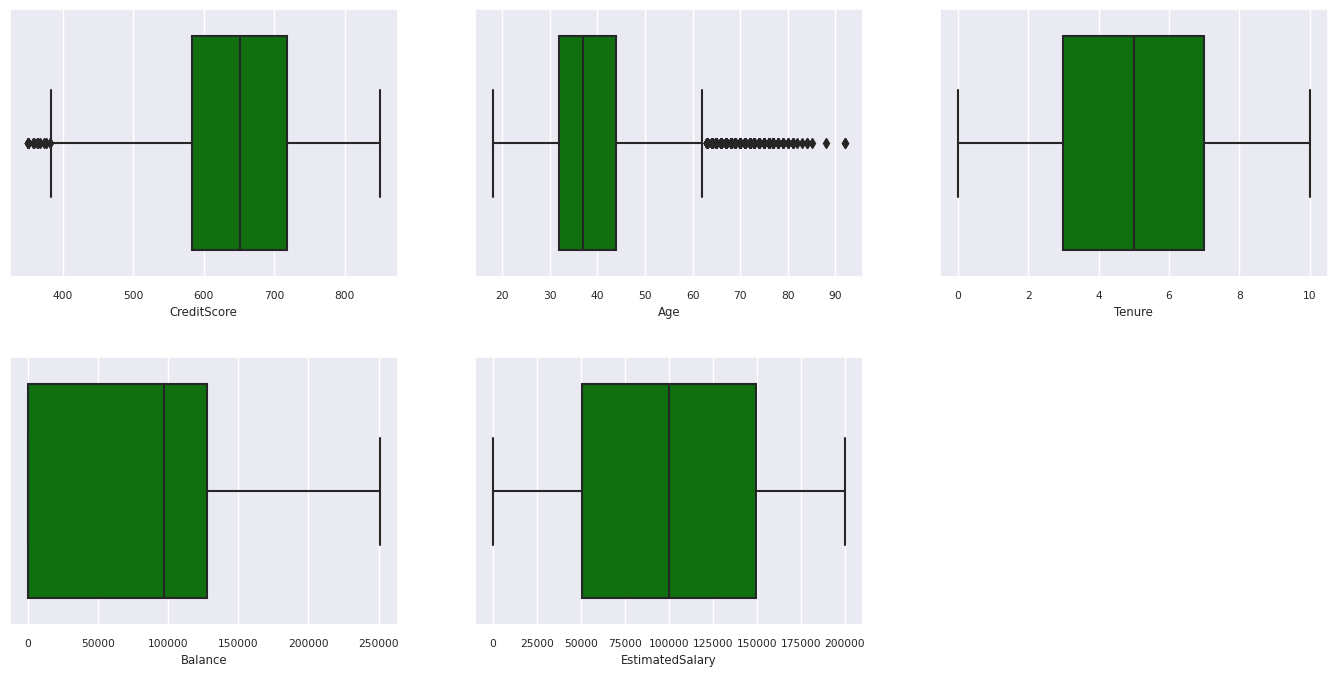

In [128]:
# Select the numerical columns from the cleaned DataFrame
df_num_cols = df_clean[numeric_variables]

# Set the font scale for Seaborn plots
sns.set(font_scale=0.7)

# Create a figure and a set of subplots with a 2x3 grid layout
fig, axes = plt.subplots(nrows=2, ncols=3, gridspec_kw=dict(hspace=0.3), figsize=(17, 8))
fig.tight_layout()

# Loop through each numerical column and corresponding axis to create box plots
for ax, col in zip(axes.flatten(), df_num_cols.columns):
    sns.boxplot(x=df_num_cols[col], color='green', ax=ax)

# Remove the last unused subplot
fig.delaxes(axes[1, 2])

# Display the plots
plt.show()

# Distribution of the target variable (Exited and Not Exited)
 The variable is unbalanced, we will have to perform SMOTE later on the training  set to balanced it. 

StatementMeta(, f0b881c3-c0bb-4915-9e39-929f42d17129, 161, Finished, Available, Finished)

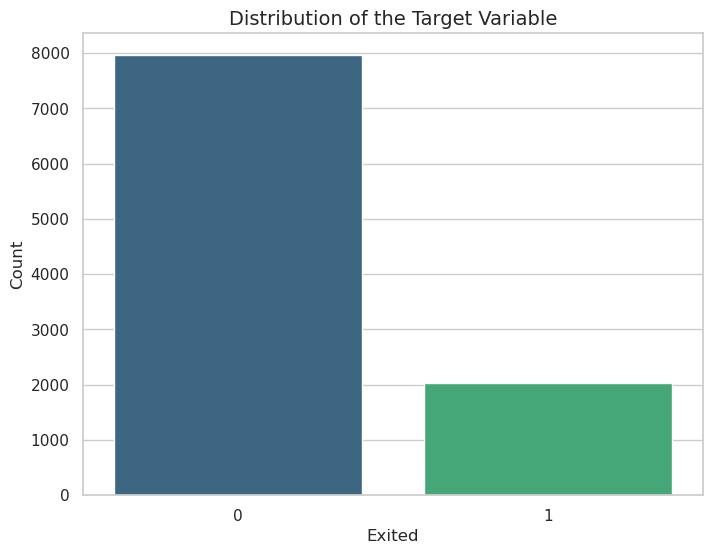

In [129]:
# Set the target variable name
target_variable = "Exited"

# Set the theme for Seaborn plots
sns.set_theme(style="whitegrid", palette="pastel")

# Create a figure and axis for the plot
fig, ax = plt.subplots(figsize=(8, 6))

# Plot the distribution of the target variable using a count plot
sns.countplot(x=df_clean[target_variable], palette="viridis", ax=ax)

# Set the title and labels for the plot
ax.set_title("Distribution of the Target Variable", fontsize=14)
ax.set_xlabel("Exited", fontsize=12)
ax.set_ylabel("Count", fontsize=12)

# Display the plot
plt.show()

# Distribution of the target variable across categorical variables.

StatementMeta(, f0b881c3-c0bb-4915-9e39-929f42d17129, 162, Finished, Available, Finished)

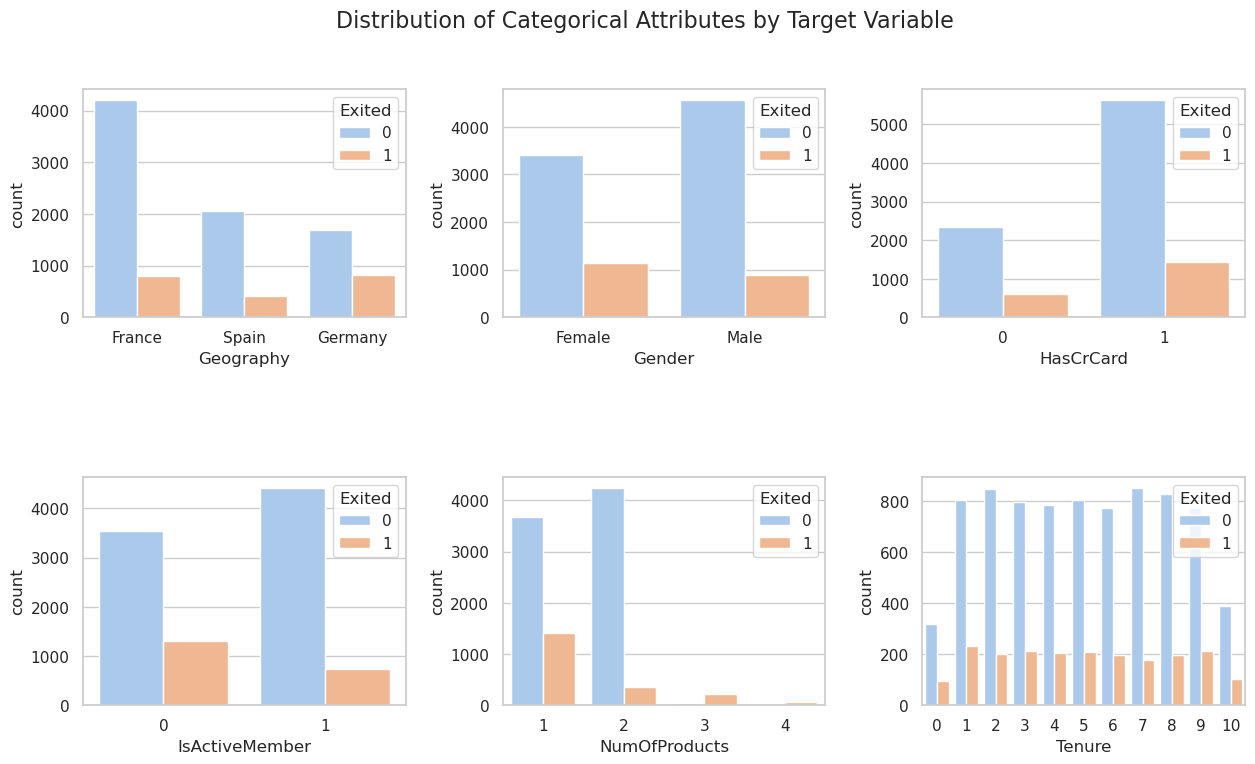

In [130]:
import seaborn as sns
import matplotlib.pyplot as plt

# List of attributes to visualize
attr_list = ['Geography', 'Gender', 'HasCrCard', 'IsActiveMember', 'NumOfProducts', 'Tenure']

# Create a figure with a 2x3 grid of subplots
fig, axarr = plt.subplots(2, 3, figsize=(15, 8))

# Loop through each attribute in the list and create a count plot
for ind, item in enumerate(attr_list):
    sns.countplot(x=item, hue='Exited', data=df_clean, ax=axarr[ind//3][ind%3])

# Adjust the layout to add space between plots
fig.subplots_adjust(hspace=0.7, wspace=0.3)

# Set the title for the entire figure
fig.suptitle('Distribution of Categorical Attributes by Target Variable', fontsize=16)

# Display the plots
plt.show()

# Frequency distribution of numerical attributes using histogram 

StatementMeta(, f0b881c3-c0bb-4915-9e39-929f42d17129, 163, Finished, Available, Finished)

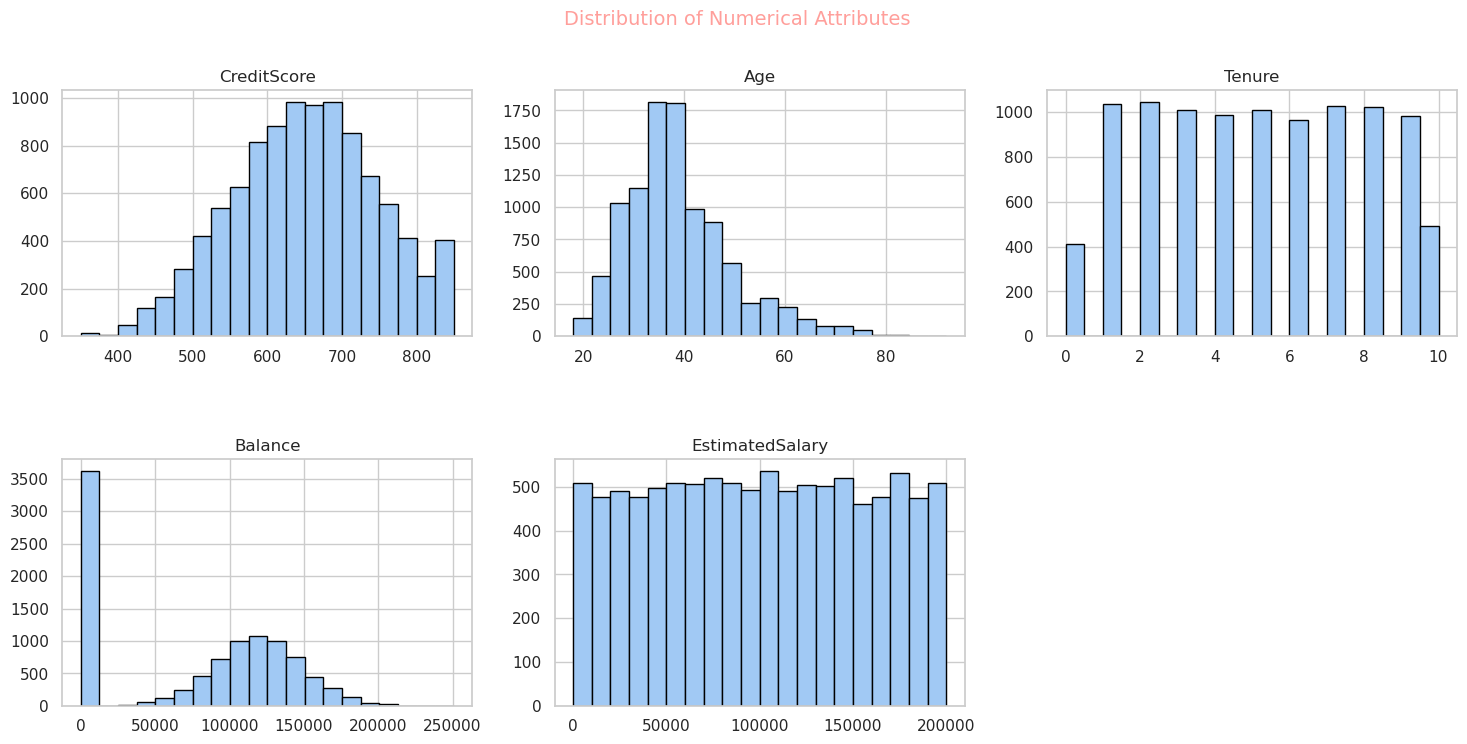

In [131]:
import matplotlib.pyplot as plt
import itertools

# Select the numerical columns from the cleaned DataFrame
columns = df_num_cols.columns[:len(df_num_cols.columns)]

# Create a figure for the histograms
fig = plt.figure()
fig.set_size_inches(18, 8)

# Determine the number of columns for subplots
length = len(columns)

# Loop through each numerical column and create a histogram
for i, j in itertools.zip_longest(columns, range(length)):
    plt.subplot((length // 2), 3, j + 1)
    plt.subplots_adjust(wspace=0.2, hspace=0.5)
    df_num_cols[i].hist(bins=20, edgecolor='black')
    plt.title(i)

# Set the overall title for the figure
fig.suptitle('Distribution of Numerical Attributes', color='r', fontsize=14)

# Display the histograms
plt.show()

# Perform Feature Engineering 
Feature engineering is the process of creating new attributes or features based on existing attributes to improve the performance of machine learning models

In [132]:
import pandas as pd

# Create a new attribute 'NewTenure' by dividing 'Tenure' by 'Age'
df_clean["NewTenure"] = df_clean["Tenure"] / df_clean["Age"]

# Create a new categorical attribute 'NewCreditScore' by binning 'CreditScore' into 6 quantiles
df_clean["NewCreditScore"] = pd.qcut(df_clean['CreditScore'], 6, labels=[1, 2, 3, 4, 5, 6])

# Create a new categorical attribute 'NewAgeScore' by binning 'Age' into 8 quantiles
df_clean["NewAgeScore"] = pd.qcut(df_clean['Age'], 8, labels=[1, 2, 3, 4, 5, 6, 7, 8])

# Create a new categorical attribute 'NewBalanceScore' by binning the ranked 'Balance' into 5 quantiles
df_clean["NewBalanceScore"] = pd.qcut(df_clean['Balance'].rank(method="first"), 5, labels=[1, 2, 3, 4, 5])

# Create a new categorical attribute 'NewEstSalaryScore' by binning 'EstimatedSalary' into 10 quantiles
df_clean["NewEstSalaryScore"] = pd.qcut(df_clean['EstimatedSalary'], 10, labels=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

# Display the first few rows of the updated DataFrame to verify the new features
print(df_clean.head())

StatementMeta(, f0b881c3-c0bb-4915-9e39-929f42d17129, 164, Finished, Available, Finished)

   CreditScore Geography  Gender  Age  Tenure    Balance  NumOfProducts  \
0          619    France  Female   42       2       0.00              1   
1          608     Spain  Female   41       1   83807.86              1   
2          502    France  Female   42       8  159660.80              3   
3          699    France  Female   39       1       0.00              2   
4          850     Spain  Female   43       2  125510.82              1   

   HasCrCard  IsActiveMember  EstimatedSalary  Exited  NewTenure  \
0          1               1        101348.88       1   0.047619   
1          0               1        112542.58       0   0.024390   
2          1               0        113931.57       1   0.190476   
3          0               0         93826.63       0   0.025641   
4          1               1         79084.10       0   0.046512   

  NewCreditScore NewAgeScore NewBalanceScore NewEstSalaryScore  
0              3           6               1                 6  
1         

# Perform one-hot encoding 


In [133]:
import pandas as pd

# Perform one-hot encoding on the 'Geography' and 'Gender' columns
df_clean = pd.get_dummies(df_clean, columns=['Geography', 'Gender'])

# Display the first few rows of the updated DataFrame to verify the changes
print(df_clean.head())

StatementMeta(, f0b881c3-c0bb-4915-9e39-929f42d17129, 165, Finished, Available, Finished)

   CreditScore  Age  Tenure    Balance  NumOfProducts  HasCrCard  \
0          619   42       2       0.00              1          1   
1          608   41       1   83807.86              1          0   
2          502   42       8  159660.80              3          1   
3          699   39       1       0.00              2          0   
4          850   43       2  125510.82              1          1   

   IsActiveMember  EstimatedSalary  Exited  NewTenure NewCreditScore  \
0               1        101348.88       1   0.047619              3   
1               1        112542.58       0   0.024390              2   
2               0        113931.57       1   0.190476              1   
3               0         93826.63       0   0.025641              5   
4               1         79084.10       0   0.046512              6   

  NewAgeScore NewBalanceScore NewEstSalaryScore  Geography_France  \
0           6               1                 6              True   
1           6       

# 

# Let's create a delta table which can used to generate Power BI Report

In [134]:
# Define the table name
table_name = "df_clean"

# Create a PySpark DataFrame from the Pandas DataFrame
sparkDF = spark.createDataFrame(df_clean)

# Save the PySpark DataFrame as a Delta table in the specified path
sparkDF.write.mode("overwrite").format("delta").save(f"Tables/{table_name}")

# Print confirmation message
print(f"Spark dataframe saved to delta table: {table_name}")

StatementMeta(, f0b881c3-c0bb-4915-9e39-929f42d17129, 166, Finished, Available, Finished)

Spark dataframe saved to delta table: df_clean


# Some observations from the exploratory data analysis 

#### 1. Customer Distribution by Country: The majority of customers are from France, indicating a larger customer base compared to Spain and Germany, with Spain exhibiting the lowest churn rate, suggesting higher customer retention.
#### 2. Credit Card Ownership: A significant portion of the customer base owns credit cards, highlighting the popularity or accessibility of credit card products among the bank’s clientele.
#### 3. Age and Credit Score: While some customers are aged above 60 and have credit scores below 400, these values are not extreme enough to be considered outliers, indicating a diverse age and credit score range within the customer base.
#### 4. Number of Bank Products: The majority of customers use one or two products from the bank, with only a small fraction utilizing more than two, suggesting limited cross-selling or product uptake.
#### 5. Activity Status and Churn Rate: Customers who are not actively engaged with the bank tend to have a higher churn rate, indicating that inactivity could be a key factor in customer attrition.
#### 6. Impact of Gender and Tenure: Analysis shows that neither gender nor the number of years a customer has been with the bank (tenure) significantly affects their likelihood of closing their account, implying these factors are less influential in churn decisions.




# Model training and tracking 

With our data prepared, we can now define the model. In this notebook, we will apply Random Forest and LightGBM models. We will use scikit-learn and lightgbm to implement these models. We will also use MLflow and Fabric Autologging to track the experiments.


In [135]:
# We will load the delta table from the lakehouse. 

# Set the random seed for reproducibility
SEED = 12345

# Load the Delta table from the specified path and convert it to a Pandas DataFrame
df_clean = spark.read.format("delta").load("Tables/df_clean").toPandas()

StatementMeta(, f0b881c3-c0bb-4915-9e39-929f42d17129, 167, Finished, Available, Finished)

# Track and Log Models with MLflow Experiments

In this section we will create experiments, define models and training parameters, specify scoring metrics, train the models, log the results, and save the trained models for future use.



In [136]:
import mlflow

# Set up experiment name
EXPERIMENT_NAME = "customer_churn_prediction_ai"  # Define the MLflow experiment name

StatementMeta(, f0b881c3-c0bb-4915-9e39-929f42d17129, 168, Finished, Available, Finished)

MLflow autologging enhances the tracking capabilities by automatically capturing the input parameters and output metrics of a machine learning model during training. This captured information is logged to your workspace, allowing you to access and visualize it using MLflow APIs or through the corresponding experiment in your workspace. Autologging simplifies the process of experiment tracking and ensures that all relevant details are recorded without manual intervention.

# Let's set experiment and autologging capabilities 

In [137]:
import mlflow

# Set the MLflow experiment with the date-stamped name
mlflow.set_experiment(EXPERIMENT_NAME)

# Enable autologging
mlflow.autolog(exclusive=False)

StatementMeta(, f0b881c3-c0bb-4915-9e39-929f42d17129, 169, Finished, Available, Finished)

2024/07/21 16:08:10 INFO mlflow.tracking.fluent: Autologging successfully enabled for lightgbm.
2024/07/21 16:08:10 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.
2024/07/21 16:08:10 INFO mlflow.tracking.fluent: Autologging successfully enabled for pyspark.ml.


# Import Scikit-learn and LightGBM

In [138]:
# Import the required libraries for model training
from sklearn.model_selection import train_test_split  # For splitting the data into training and testing sets
from lightgbm import LGBMClassifier  # LightGBM classifier for gradient boosting
from sklearn.ensemble import RandomForestClassifier  # Random Forest classifier for ensemble learning
from sklearn.metrics import (
    accuracy_score,  # For calculating accuracy of the model
    f1_score,  # For calculating F1 score
    precision_score,  # For calculating precision
    confusion_matrix,  # For generating confusion matrix
    recall_score,  # For calculating recall
    roc_auc_score,  # For calculating ROC AUC score
    classification_report  # For generating classification report
)

StatementMeta(, f0b881c3-c0bb-4915-9e39-929f42d17129, 170, Finished, Available, Finished)

# Prepare the training and test dataset.

In [139]:
# Separate the target variable from the features
y = df_clean["Exited"]
X = df_clean.drop("Exited", axis=1)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=SEED)

StatementMeta(, f0b881c3-c0bb-4915-9e39-929f42d17129, 171, Finished, Available, Finished)

# Apply SMOTE to the training data to generate new samples for the minority class

We apply SMOTE only to the training dataset. The test dataset must retain its original imbalanced distribution to provide a valid approximation of how the model will perform on the original data, reflecting the production environment

In [140]:
# Let's install imblearn
%pip install imblearn 

StatementMeta(, f0b881c3-c0bb-4915-9e39-929f42d17129, 177, Finished, Available, Finished)


[notice] A new release of pip is available: 23.1.2 -> 24.1.2
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.



In [141]:
import pandas as pd
from collections import Counter
from imblearn.over_sampling import SMOTE
SEED = 12345

# Initialize SMOTE with a random seed for reproducibility
sm = SMOTE(random_state=SEED)

# Apply SMOTE to the training data to generate new samples for the minority class
X_res, y_res = sm.fit_resample(X_train, y_train)

# Concatenate the resampled features and target into a new training DataFrame
new_train = pd.concat([pd.DataFrame(X_res, columns=X_train.columns), pd.DataFrame(y_res, columns=["Exited"])], axis=1)

StatementMeta(, f0b881c3-c0bb-4915-9e39-929f42d17129, 179, Finished, Available, Finished)

NameError: name 'X_train' is not defined

# Train the models

# Random Forest: 
Maximum depth of 4 with four features 

In [ ]:
import mlflow
import mlflow.sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Enable autologging for scikit-learn with model registration
mlflow.sklearn.autolog(registered_model_name='rfc1_sm')

# Initialize the Random Forest Classifier with specified hyperparameters
rfc1_sm = RandomForestClassifier(max_depth=4, max_features=4, min_samples_split=3, random_state=SEED)

# Start an MLflow run to train and log the model
with mlflow.start_run(run_name="rfc1_sm") as run:
    rfc1_sm_run_id = run.info.run_id  # Capture run_id for model prediction later
    print(f"run_id: {rfc1_sm_run_id}; status: {run.info.status}")
    
    # Fit the model on the resampled (balanced) training data
    rfc1_sm.fit(X_res, y_res.ravel())
    
    # Evaluate the model on the test data
    score = rfc1_sm.score(X_test, y_test)
    y_pred = rfc1_sm.predict(X_test)
    
    # Generate classification report and confusion matrix
    cr_rfc1_sm = classification_report(y_test, y_pred)
    cm_rfc1_sm = confusion_matrix(y_test, y_pred)
    
    # Calculate ROC AUC score for the model
    roc_auc_rfc1_sm = roc_auc_score(y_test, rfc1_sm.predict_proba(X_test)[:, 1])
    
    # Log additional metrics manually
    mlflow.log_metric("roc_auc", roc_auc_rfc1_sm)

    # Print the evaluation results
    print(f"Classification Report:\n{cr_rfc1_sm}")
    print(f"Confusion Matrix:\n{cm_rfc1_sm}")
    print(f"ROC AUC Score: {roc_auc_rfc1_sm}")

StatementMeta(, , , Cancelled, , Cancelled)

# Random Forest:
Train model using maximum depth of 8 with 8 features 


In [ ]:
import mlflow
import mlflow.sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Enable autologging for scikit-learn with model registration
mlflow.sklearn.autolog(registered_model_name='rfc2_sm')

# Initialize the second Random Forest Classifier with specified hyperparameters
rfc2_sm = RandomForestClassifier(max_depth=8, max_features=6, min_samples_split=3, random_state=SEED)

# Start an MLflow run to train and log the model
with mlflow.start_run(run_name="rfc2_sm") as run:
    rfc2_sm_run_id = run.info.run_id  # Capture run_id for model prediction later
    print(f"run_id: {rfc2_sm_run_id}; status: {run.info.status}")
    
    # Fit the model on the resampled (balanced) training data
    rfc2_sm.fit(X_res, y_res.ravel())
    
    # Evaluate the model on the test data
    score = rfc2_sm.score(X_test, y_test)
    y_pred = rfc2_sm.predict(X_test)
    
    # Generate classification report and confusion matrix
    cr_rfc2_sm = classification_report(y_test, y_pred)
    cm_rfc2_sm = confusion_matrix(y_test, y_pred)
    
    # Calculate ROC AUC score for the model
    roc_auc_rfc2_sm = roc_auc_score(y_test, rfc2_sm.predict_proba(X_test)[:, 1])
    
    # Log additional metrics manually
    mlflow.log_metric("roc_auc", roc_auc_rfc2_sm)

    # Print the evaluation results
    print(f"Classification Report:\n{cr_rfc2_sm}")
    print(f"Confusion Matrix:\n{cm_rfc2_sm}")
    print(f"ROC AUC Score: {roc_auc_rfc2_sm}")

StatementMeta(, , , Cancelled, , Cancelled)

# Train LightGBM

In [ ]:
import mlflow
import mlflow.lightgbm
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score

# Enable autologging for LightGBM with model registration
mlflow.lightgbm.autolog(registered_model_name='lgbm_sm')

# Initialize the LightGBM Classifier with specified hyperparameters
lgbm_sm_model = LGBMClassifier(
    learning_rate=0.07, 
    max_delta_step=2, 
    n_estimators=100,
    max_depth=10, 
    eval_metric="logloss", 
    objective='binary', 
    random_state=42
)

# Start an MLflow run to train and log the model
with mlflow.start_run(run_name="lgbm_sm") as run:
    lgbm1_sm_run_id = run.info.run_id  # Capture run_id for model prediction later
    print(f"run_id: {lgbm1_sm_run_id}; status: {run.info.status}")
    
    # Fit the model on the resampled (balanced) training data
    lgbm_sm_model.fit(X_res, y_res.ravel())
    
    # Generate predictions on the test data
    y_pred = lgbm_sm_model.predict(X_test)
    
    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    cr_lgbm_sm = classification_report(y_test, y_pred)
    cm_lgbm_sm = confusion_matrix(y_test, y_pred)
    roc_auc_lgbm_sm = roc_auc_score(y_test, lgbm_sm_model.predict_proba(X_test)[:, 1])
    
    # Log additional metrics manually
    mlflow.log_metric("accuracy", accuracy)
    mlflow.log_metric("roc_auc", roc_auc_lgbm_sm)

    # Print the evaluation results
    print(f"Classification Report:\n{cr_lgbm_sm}")
    print(f"Confusion Matrix:\n{cm_lgbm_sm}")
    print(f"ROC AUC Score: {roc_auc_lgbm_sm}")

StatementMeta(, , , Cancelled, , Cancelled)

# Examine Experiments artifact for tracking model performance

The experiment runs are automatically saved as artifacts within your workspace. They are named based on the experiment name you specified. All trained models, their runs, performance metrics, and model parameters are logged and can be viewed from the experiment page, as shown in the image below.

To view your experiments:

On the left panel, select your workspace.
Find and select the experiment name, in this case, sample-bank-churn-experiment.


# Evaluate and save the final machine learning model

In [ ]:
# Define URIs to fetch the models
run_uri_rfc1_sm = f"runs:/{rfc1_sm_run_id}/model"
run_uri_rfc2_sm = f"runs:/{rfc2_sm_run_id}/model"
run_uri_lgbm1_sm = f"runs:/{lgbm1_sm_run_id}/model"

# Load the trained models using their run URIs
load_model_rfc1_sm = mlflow.sklearn.load_model(run_uri_rfc1_sm)
load_model_rfc2_sm = mlflow.sklearn.load_model(run_uri_rfc2_sm)
load_model_lgbm1_sm = mlflow.lightgbm.load_model(run_uri_lgbm1_sm)

StatementMeta(, , , Cancelled, , Cancelled)

# Performance of the save models on the test dataset. 

In [ ]:
# Make predictions on the test data using the loaded Random Forest models and LightGBM model
ypred_rfc1_sm = load_model_rfc1_sm.predict(X_test)  # Random Forest with max depth of 4 and 4 features
ypred_rfc2_sm = load_model_rfc2_sm.predict(X_test)  # Random Forest with max depth of 8 and 6 features
ypred_lgbm1_sm = load_model_lgbm1_sm.predict(X_test)  # LightGBM

StatementMeta(, , , Cancelled, , Cancelled)

# Display True/False Positives/Negatives using the Confusion Matrix

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion Matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    print(cm)
    plt.figure(figsize=(4, 4))
    plt.rcParams.update({'font.size': 10})
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, color="blue")
    plt.yticks(tick_marks, classes, color="blue")

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="red" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Generate confusion matrices for the predictions
cm_rfc1_sm = confusion_matrix(y_test, ypred_rfc1_sm)
cm_rfc2_sm = confusion_matrix(y_test, ypred_rfc2_sm)
cm_lgbm1_sm = confusion_matrix(y_test, ypred_lgbm1_sm)

# Plot confusion matrices for each model
plot_confusion_matrix(cm_rfc1_sm, classes=['Not Churned', 'Churned'], title='Confusion Matrix: RFC1_SM')
plt.show()
plot_confusion_matrix(cm_rfc2_sm, classes=['Not Churned', 'Churned'], title='Confusion Matrix: RFC2_SM')
plt.show()
plot_confusion_matrix(cm_lgbm1_sm, classes=['Not Churned', 'Churned'], title='Confusion Matrix: LGBM1_SM')
plt.show()

StatementMeta(, , , Cancelled, , Cancelled)

A confusion matrix for the Random Forest Classifier with a maximum depth of four and four features

In [ ]:
from sklearn.metrics import confusion_matrix

# Generate the confusion matrix for Random Forest Classifier with max depth of 4 and 4 features
cfm = confusion_matrix(y_test, y_pred=ypred_rfc1_sm)

# Plot the confusion matrix
plot_confusion_matrix(cfm, classes=['Non Churn', 'Churn'],
                      title='Random Forest with Max Depth of 4')

# Extract true negatives (tn), false positives (fp), false negatives (fn), and true positives (tp) from the confusion matrix
tn, fp, fn, tp = cfm.ravel()

StatementMeta(, , , Cancelled, , Cancelled)

A confusion matrix for Random Forest Classifier with maximum depth of eight, with six features.

In [ ]:
from sklearn.metrics import confusion_matrix

# Generate the confusion matrix for Random Forest Classifier with max depth of 8 and 6 features
cfm = confusion_matrix(y_test, y_pred=ypred_rfc2_sm)

# Plot the confusion matrix
plot_confusion_matrix(cfm, classes=['Non Churn', 'Churn'],
                      title='Random Forest with Max Depth of 8')

# Extract true negatives (tn), false positives (fp), false negatives (fn), and true positives (tp) from the confusion matrix
tn, fp, fn, tp = cfm.ravel()

StatementMeta(, , , Cancelled, , Cancelled)

Create the confusion matrix for LightGBM.

In [ ]:
from sklearn.metrics import confusion_matrix

# Generate the confusion matrix for the LightGBM Classifier
cfm = confusion_matrix(y_test, y_pred=ypred_lgbm1_sm)

# Plot the confusion matrix
plot_confusion_matrix(cfm, classes=['Non Churn', 'Churn'],
                      title='LightGBM')

# Extract true negatives (tn), false positives (fp), false negatives (fn), and true positives (tp) from the confusion matrix
tn, fp, fn, tp = cfm.ravel()

StatementMeta(, , , Cancelled, , Cancelled)

# Let's save the results for Power BI

Move model prediction results to Power BI Visualization by saving delta frame to lakehouse.


In [ ]:
# Copy the test features DataFrame
df_pred = X_test.copy()

# Add the true labels and predictions to the DataFrame
df_pred['y_test'] = y_test
df_pred['ypred_rfc1_sm'] = ypred_rfc1_sm
df_pred['ypred_rfc2_sm'] = ypred_rfc2_sm
df_pred['ypred_lgbm1_sm'] = ypred_lgbm1_sm

# Define the table name for saving the results
table_name = "df_pred_results"

# Convert the Pandas DataFrame to a Spark DataFrame
sparkDF = spark.createDataFrame(df_pred)

# Save the Spark DataFrame as a Delta table with overwrite mode
sparkDF.write.mode("overwrite").format("delta").option("overwriteSchema", "true").save(f"Tables/{table_name}")

# Print confirmation message
print(f"Spark dataframe saved to delta table: {table_name}")

StatementMeta(, , , Cancelled, , Cancelled)

# Business Intelligence via Visualizations in Power BI

Steps to Access Your Saved Table in Power BI

On the left, select OneLake data hub.
Select the lakehouse that you added to this notebook.
On the top right, select Open under the section titled Open this Lakehouse.
On the top ribbon, select New Power BI dataset, choose df_pred_results, and then click Continue to create a new Power BI dataset linked to the predictions.
On the tools at the top of the dataset page, select New report to open the Power BI report authoring page.

Below are some example visualizations. The data panel displays the delta tables and columns from which you can select. After choosing the appropriate x and y axes, you can apply filters and functions such as the sum or average of a table column.

	[!NOTE]
This is an illustrative example of how you would analyze the saved prediction results in Power BI. For a real customer churn use-case, platform users may need to ideate more thoroughly on what visualizations to create based on subject matter expertise and the metrics standardized by their firm and business analytics team.

# 

# Insights from the Power BI Report 

Insights from the Power BI Report

Churn Rate and Number of Products:
The report indicates that customers who use more than two of the bank’s products have a higher churn rate, despite the fact that few customers actually use more than two products. This suggests that the bank should collect more data and investigate other features that are correlated with the use of multiple products (see the plot in the bottom left panel).
Geographical Churn Rate:
The report shows that bank customers in Germany have a higher churn rate compared to those in France and Spain (see the plot in the bottom right panel). This suggests that an investigation into the reasons behind customer attrition in Germany could be beneficial.
Age and Churn Rate:
There are more middle-aged customers (between 25-45), and customers between 45-60 tend to exit more frequently.
Credit Scores and Churn Rate:
Customers with lower credit scores are more likely to leave the bank for other financial institutions. The bank should explore ways to encourage customers with lower credit scores and account balances to remain with the bank.

These insights can help the bank focus its efforts on retaining customers and reducing churn by addressing the specific factors identified in the report.

In [ ]:
import time

# Record the start time at the beginning of your script
ts = time.time()

# Your script's code goes here...

# Calculate and print the total runtime
print(f"Full run cost {int(time.time() - ts)} seconds.")

StatementMeta(, , , Cancelled, , Cancelled)

# 